In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 22 09:17:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/GAN/

Mounted at /content/drive
/content/drive/MyDrive/GAN


In [2]:
import sys
#sys.path.append('/Users/uri.almog/tsubu/GAN-main/')


import pandas as pd
import io
import datetime as dt
from IPython.display import FileLink
import datetime
from datetime import datetime, timedelta, date
import numpy as np
import warnings 

from tqdm import tqdm

pd.set_option("display.max_columns", None)

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
#import plotly.express as px

import tensorflow as tf
from tensorflow.keras.optimizers import SGD

import sklearn
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#import graphviz

import pickle

from ipywidgets import IntProgress
from IPython.display import display
import time

from IPython.display import display, clear_output

import requests

requests.packages.urllib3.disable_warnings()
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
import models
from models import deep_model
from models import gan_class
from models.gan_class import GAN

In [4]:
models

<module 'models' from '/Users/uri.almog/uri_tsubu_git_with_ssh/GAN/models/__init__.py'>

In [20]:


"""
Data preparation
"""

mnist_train, mnist_test = tf.keras.datasets.mnist.load_data('mnist.npz')


mnist_train_vectors, mnist_train_labels = mnist_train

ind_array = np.arange(len(mnist_train_vectors))

mnist_train_indices_label_8 = np.where(mnist_train_labels == 8)
mnist_train_vectors_8 = mnist_train_vectors[mnist_train_indices_label_8]
ind_array_label_8 = np.arange(len(mnist_train_vectors_8))

mnist_train_indices_label_0 = np.where(mnist_train_labels == 0)
mnist_train_vectors_0 = mnist_train_vectors[mnist_train_indices_label_0]
ind_array_label_0 = np.arange(len(mnist_train_vectors_0))

mnist_train_indices_label_2 = np.where(mnist_train_labels == 2)
mnist_train_vectors_2 = mnist_train_vectors[mnist_train_indices_label_2]
ind_array_label_2 = np.arange(len(mnist_train_vectors_2))

mnist_train_indices_label_1 = np.where(mnist_train_labels == 1)
mnist_train_vectors_1 = mnist_train_vectors[mnist_train_indices_label_1]
ind_array_label_1 = np.arange(len(mnist_train_vectors_1))

mnist_train_vectors.shape
#scaler = StandardScaler()
#scaler.fit(mnist_train_vectors)
#scaled_data = scaler.transform(mnist_train_vectors)



(60000, 28, 28)

In [6]:
#from gan_utils import *

In [21]:
def general_scale_data(x):
    #scaling the input:
    is_3d_data = np.False_
    scaler = StandardScaler()
    print('data shape is: ', x.shape)
    if len(x.shape) == 3:
      is_3d_data = True
      dim0, dim1, dim2 = x.shape
      x = x.reshape(-1, x.shape[-2]*x.shape[-1])

    scaler.fit(x)
    #display(scaler.mean_)
    #display(scaler.scale_)
    scaleddata = scaler.transform(x)
    if is_3d_data:
      scaleddata = scaleddata.reshape(dim0, dim1, dim2)
    return scaler, scaleddata

In [69]:
dataset = mnist_train_vectors[:8,:,:]
scaler, scaleddata = general_scale_data(dataset)

#scaler=None
#scaleddata=dataset

data shape is:  (8, 28, 28)


In [62]:
latent_dim = 100
output_dim = (28, 28, 1)


#source for mnist gan architecture:
#https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

# size of the latent space

mygan = GAN(isplot=True,
            lr=0.0002,
            decay_rate=0.9)

# create the discriminator
type(scaleddata.shape)
mygan.set_batches_per_epoch(dataset=mnist_train_vectors,
                            batch_size=256)

mygan.define_discriminator(output_dim,
                           [{'type':'Conv', 'filters':64 , 'activation':'LeakyReLU', 'kernel':(3, 3), 'kernel_reg':None,'strides': (2, 2), 'padding':'same', 'use_bias':True, 'input_shape':output_dim},
                            {'type':'dropout', 'rate':0.4},
                            {'type':'Conv', 'filters':64, 'activation':'LeakyReLU', 'kernel':(3, 3), 'kernel_reg':None, 'strides':(2, 2), 'padding':'same', 'use_bias':True},
                            {'type':'dropout', 'rate':0.4},
                            {'type':'flatten'},
                            {'type':'Dense', 'nodes':1, 'activation':'sigmoid', 'use_bias':True}])
# create the generator
mygan.define_generator(latent_dim,
                       [{'type':'Dense', 'nodes':7*7*128, 'activation':'LeakyReLU', 'use_bias':False},
                        {'type':'Reshape', 'newshape':[7, 7, 128]},
                        {'type':'Deconv', 'filters':128, 'kernel': (4, 4), 'strides': (2, 2), 'use_bias': False, 'padding': 'same', 'activation':'LeakyReLu'},
                        {'type':'Deconv', 'filters':128, 'kernel': (4, 4), 'strides': (2, 2), 'use_bias': False, 'padding': 'same', 'activation':'linear'},
                        {'type':'leakyrelu'},
                        {'type':'Conv', 'filters':1, 'kernel': (7, 7), 'kernel_reg':None, 'strides': (1, 1), 'use_bias': False, 'padding': 'same', 'activation':'sigmoid'}])



# create the gan
gan_model = mygan.define_gan()

print(mygan.discriminator.summary())
print(mygan.generator.summary())







Discriminator is now defined
Generator is now defined
GAN is now defined
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 13, 13, 64)        640       
                                                                 
 dropout_34 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 dropout_35 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_17 (Flatten)        (None, 3136)              0         
                                                                 
 dense_34 (Dense)            (None, 1)                 3137      
                                              

In [63]:
#scaleddata.shape

In [70]:
scaler

StandardScaler()

In [ ]:
# train model
mygan.train(scaleddata, 
            n_epochs=5, 
            n_batch=4,  
            n_eval=1)


if __name__ == "__main__":
    print('hello')

**** now training gan ***


IntProgress(value=0, max=234)

value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4


/Users/uri.almog/datascience/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 23ms/step
value of input:  4
1/1 [==============================] - 0s 22ms/step
value of input:  4
1/1 [==============================] - 0s 29ms/step
value of input:  4
1/1 [==============================] - 0s 20ms/step
value of input:  4
1/1 [==============================] - 0s 23ms/step
value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4
1/1 [==============================] - 0s 23ms/step
value of input:  4
1/1 [==============================] - 0s 22ms/step
value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4
1/1 [==============================] - 0s 29ms/step
value of input:  4
1/1 [==============================] - 0s 22ms/step
value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4
1/1 [==============================] - 0s 25ms/step
value of input:  4
1/1 [==============================] - 0s 24ms/step
value of input:  4
1/1 [=

1/1 [==============================] - 0s 19ms/step
value of input:  4
1/1 [==============================] - 0s 20ms/step
value of input:  4
1/1 [==============================] - 0s 20ms/step
value of input:  4
1/1 [==============================] - 0s 19ms/step
value of input:  4
1/1 [==============================] - 0s 20ms/step
value of input:  4
1/1 [==============================] - 0s 20ms/step
value of input:  4
1/1 [==============================] - 0s 24ms/step
value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4
1/1 [==============================] - 0s 20ms/step
value of input:  4
1/1 [==============================] - 0s 19ms/step
value of input:  4
1/1 [==============================] - 0s 22ms/step
value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4
1/1 [==============================] - 0s 19ms/step
value of input:  4
1/1 [==============================] - 0s 21ms/step
value of input:  4
1/1 [=

In [ ]:
mygan

In [ ]:
import keras
mygan.generator = keras.models.load_model('None_temp_generator_epoch_29_0.76_0.43.model')
mygan.discriminator = keras.models.load_model('None_temp_discriminator_epoch_29_0.76_0.43.model')
mygan.gan = keras.models.load_model('None_temp_gan_epoch_29_0.76_0.43.model')


epoch number:  3
learning rate: 0.0002000000


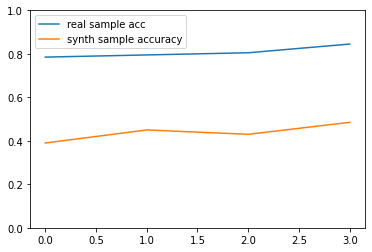

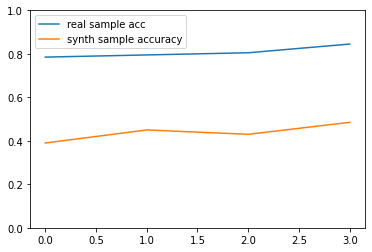

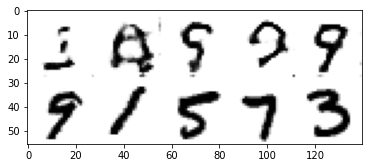

IntProgress(value=0, max=234)

4/4 [==============================] - 0s 6ms/step


In [ ]:
mygan.train(mnist_train_vectors, 
            n_epochs=100, 
            n_batch=256,  
            n_eval=1)

epoch number:  99
learning rate: 0.0002000000


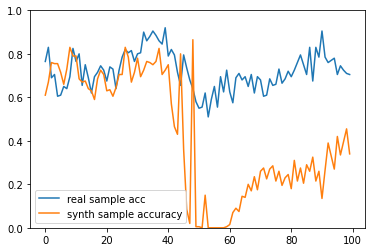

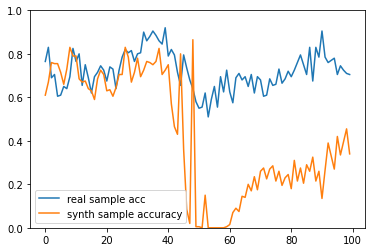

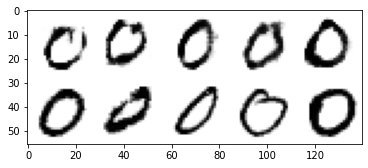

>>> saving intermediate model


In [ ]:
mygan.train(mnist_train_vectors_0, 
            n_epochs=100, 
            n_batch=256,  
            n_eval=1)